# Machine Learning Project

## Table of Contents
- [Import Data](#import-data)
  - [Import Data Summary](#import-data-summary)
- [Data Exploration](#data-exploration)
  - [Boolean Features](#boolean-features)
    - [Boolean Features Analysis](#boolean-features-analysis)
  - [Categorical Features](#categorical-features)
    - [Check Categorical Features Consistency](#check-categorical-features-consistency)
    - [Categorical Features Summary](#categorical-features-summary)
  - [Numerical Features](#numerical-features)
    - [Numerical Plots](#plots)
    - [Analysis of Numerical Distributions](#analysis-of-numerical-distributions)
- [Pre-processing](#pre-processing)
  - [Summary of Preprocessing Pipeline](#preprocessing-pipeline-summary)
  - [Data Preparation](#data-preparation)
    - [Correlation Analysis](#correlation-analysis)
- [Model Training](#model-training)
  - [Model Selection with Cross-Validation](#model-selection-with-cv)
  - [Quick Baseline Model](#quick-baseline-model)
  - [Experiment Algorithms](#experiment-algorithms)
- [Predictions](#predictions)

<a id="import-data"></a>
## Import Data

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import loguniform, randint
from model_training_utils import (
    general_cleaning,
    preprocess_data,
    cross_validate_with_tuning,
    preprocess_test_data
)

SEED = 42

warnings.filterwarnings('ignore')

In [16]:
df = pd.read_csv('data/train.csv').set_index('carID')
df.head()

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75973 entries, 69512 to 15795
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           74452 non-null  object 
 1   model           74456 non-null  object 
 2   year            74482 non-null  float64
 3   price           75973 non-null  int64  
 4   transmission    74451 non-null  object 
 5   mileage         74510 non-null  float64
 6   fuelType        74462 non-null  object 
 7   tax             68069 non-null  float64
 8   mpg             68047 non-null  float64
 9   engineSize      74457 non-null  float64
 10  paintQuality%   74449 non-null  float64
 11  previousOwners  74423 non-null  float64
 12  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 8.1+ MB


In [18]:
num_duplicated_ids = df.index.duplicated().sum()
print(f'Number of duplicated carIDs: {num_duplicated_ids}')

Number of duplicated carIDs: 0


<a id="import-data-summary"></a>
#### Import Data Summary
- Dataset loaded successfully with `carID` as the index
- There are no duplicate entries in carID
- The dataset contains information about cars including both numerical features (price, mileage, tax, etc.) and categorical features (brand, model, transmission, etc.)
- Initial inspection shows multiple features that will require preprocessing:
  - Numerical features that need cleaning (negative values, outliers)
  - Categorical features that need standardization
  - Presence of missing values in several columns

<a id="data-exploration"></a>
## Data Exploration

<a id="boolean-features"></a>
### Boolean Features

In [19]:
df['hasDamage'].value_counts(dropna=False)

hasDamage
0.0    74425
NaN     1548
Name: count, dtype: int64

<a id="boolean-features-analysis"></a>
#### Boolean Features Analysis

Key observations about `hasDamage` feature:
- Only contains binary values (0) and NaN
- No instances of value 1 found, suggesting potential data collection issues
- May indicate:
  - Cars with damage not being listed
  - System default setting of 0 for non-damaged cars
  - Incomplete damage assessment process
- Requires special handling in preprocessing:
  - Consider treating NaN as a separate category
  - Validate if 0 truly represents "no damage"
  - May need to be treated as a categorical rather than boolean feature

<a id="categorical-features"></a>
### Categorical Features

<a id="check-categorical-features-consistency"></a>
#### Check Categorical Features Consistency

In [20]:
# List of categorical features
cat_cols = ['Brand', 'model', 'fuelType', 'transmission']

# Identify outlier examples in categorical features
cat_outliers_examples = {col: df[col].value_counts().tail(10).index for col in cat_cols}

# Display the outlier examples
pd.DataFrame(cat_outliers_examples)

,Brand,model,fuelType,transmission
0,mercede,GOLF SV,Othe,utomati
1,kod,tiguan,ther,manual
2,AUD,CLK,Electric,AUTOMATI
3,KODA,gtc,YBRID,emi-Aut
4,HYUNDA,Gol,OTHER,Other
5,OYOTA,M5,other,semi-aut
6,SKOD,gls class,HYBRI,manua
7,TOYOT,Mokka,ybri,UTOMATIC
8,skod,6 Serie,ETRO,manual
9,toyot,JETTA,IESE,nknow


<a id="categorical-features-summary"></a>
#### Categorical Features Summary
- Initial analysis reveals significant data quality issues across all categorical columns
- No standardization in categorical features, with multiple variations of the same values (different spellings, capitalizations)
- Solution: We will implement string distance-based standardization using the `nltk` library to clean and standardize these features

<a id="numerical-features"></a>
### Numerical Features

In [21]:
# Dict of numerical features
num_cols = {
    'price': 'continuous',
    'mileage': 'continuous',
    'tax': 'continuous',
    'mpg': 'continuous',
    'paintQuality%': 'continuous',
    'engineSize': 'continuous',
    'year': 'discrete',
    'previousOwners': 'discrete'
}

<a id="plots"></a>
#### Numerical Plots

In [22]:
# Plot figures for numerical features and the target variable (price)
plt.figure(figsize=(16, 10))
for i, (col, var_type) in enumerate(num_cols.items(), 1):
    plt.subplot(4, 2, i)

    # Plot based on variable type
    if var_type == 'continuous':
        sns.histplot(data=df, x=col, kde=True, color="lightcoral", bins=30)
        plt.title(f"Distribution of {col}", fontsize=11)
    elif var_type == 'discrete':
        sns.countplot(data=df, x=col, color="lightcoral")
        plt.title(f"Distribution of {col}", fontsize=11)
        plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

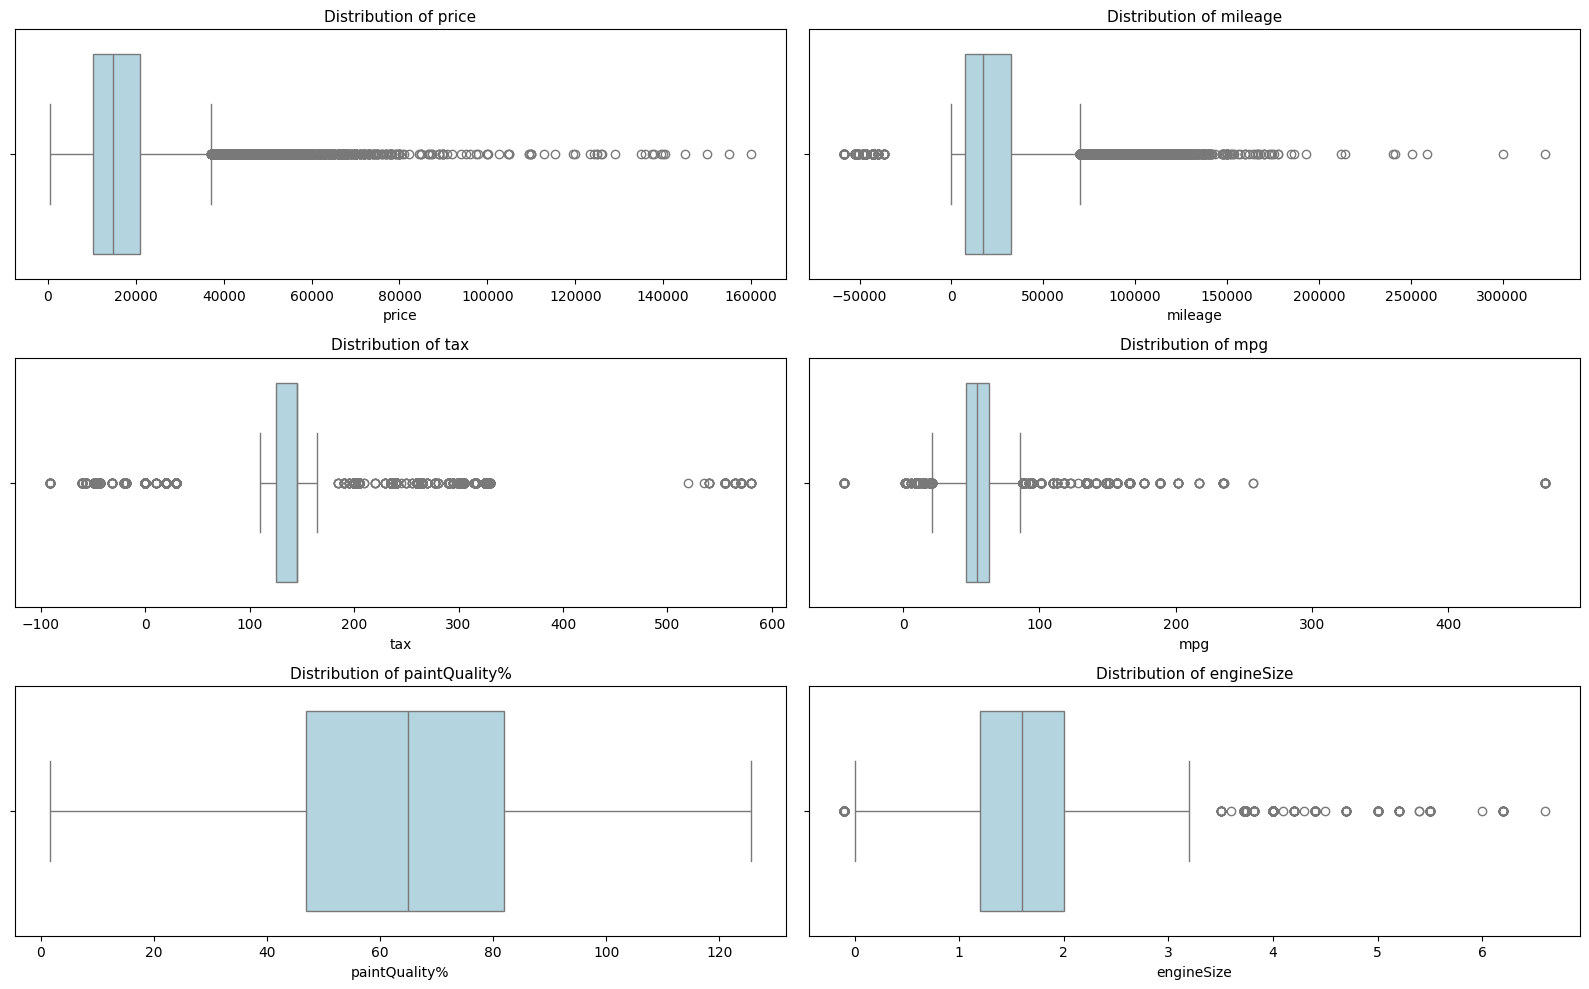

In [ ]:
# Boxplots for continuous numerical features and the target variable (price)
continuous_cols = [col for col, var_type in num_cols.items() if var_type == 'continuous']
plt.figure(figsize=(16, 10))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df, x=col, color="lightblue")
    plt.title(f"Distribution of {col}", fontsize=11)

plt.tight_layout()
plt.show()

<a id="analysis-of-numerical-distributions"></a>
#### Analysis of Numerical Distributions

Key observations from the plots:
- **Target Variable (Price)**:
  - Highly right-skewed distribution
  - Contains significant number of outliers in the upper range
  - Most cars are concentrated in the lower price range

- **Mileage**:
  - Right-skewed distribution
  - Large range from nearly new cars to high-mileage vehicles
  - Some outliers in upper range suggesting possible data entry errors

- **Tax**:
  - Multiple peaks suggesting different tax bands
  - Contains negative values which require investigation (possible tax benefits/rebates)
  - Large number of outliers on both ends of the distribution

- **MPG (Miles Per Gallon)**:
  - Approximately normal distribution with slight right skew
  - Some unrealistic extreme values that need cleaning
  - Reasonable median around typical car efficiency ranges

- **Paint Quality %**:
  - Contains values above 100% which are logically impossible
  - Left-skewed distribution suggesting optimistic ratings
  - Requires standardization to 0-100 range

- **Engine Size**:
  - There are engine size with zero values which are not realistic (might indicate electric vehicles)
  - Some unusual patterns that need investigation
  - Contains outliers that may represent specialty vehicles

- **Year**:
  - Should be discrete but contains decimal values

- **Previous Owners**:
  - Should be integer but contains float values
  - Right-skewed distribution as expected
  - Maximum values need validation (unusually high number of previous owners)

<a id="pre-processing"></a>
## Pre-processing

<a id="preprocessing-pipeline-summary"></a>
## Summary of Preprocessing Pipeline

The preprocessing is now properly separated:

1. **`preprocess_data()`** - Preprocesses a single dataset
   - Handles categorical features (standardization, encoding)
   - Handles numerical outliers using IQR method
   - Imputes missing values with medians
   - One-hot encodes categorical features
   - Normalizes numerical features with StandardScaler
   - Can fit transformers (fit=True) or use existing ones (fit=False)

2. **`cross_validate_with_tuning()`** - Performs CV with hyperparameter tuning
   - Takes **raw data** (after general_cleaning)
   - Applies preprocessing **separately for each fold** (prevents data leakage)
   - Performs manual hyperparameter search by sampling from parameter distributions
   - Evaluates each combination on validation fold and tracks train/validation performance
   - Returns best model trained on all data + preprocessing artifacts

3. **`preprocess_test_data()`** - Preprocesses test data
   - Uses artifacts from CV to ensure consistency

<a id="data-preparation"></a>
### Data Preparation

In [ ]:
# Prepare cleaned data for cross-validation
df_cleaned = general_cleaning(df)
X = df_cleaned.drop(columns=["price"])
y = df_cleaned["price"]

# Remove 'price' from num_cols since it's the target
del num_cols['price']

print(f"Dataset size: {X.shape}")
print(f"Target range: £{y.min():.2f} - £{y.max():.2f}")
print(f"\nReady for cross-validation!")

Dataset size: (75973, 12)
Target range: £450.00 - £159999.00

Ready for cross-validation!


<a id="correlation-analysis"></a>
#### Correlation Analysis

Before model training, let's examine correlations between numerical features to understand their relationships.

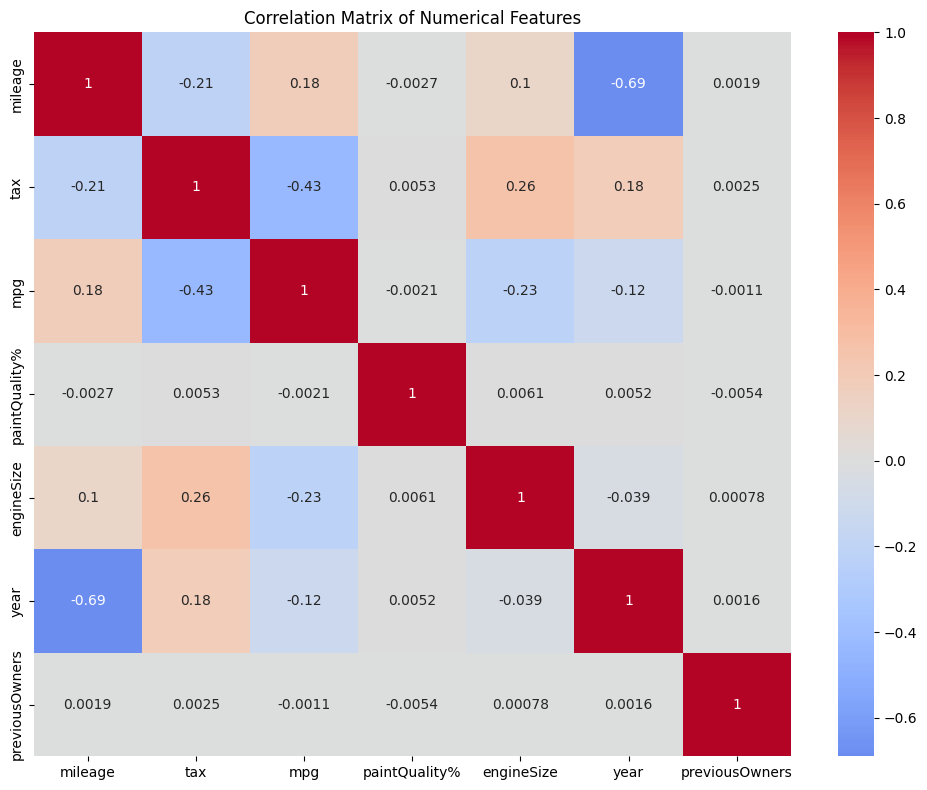

In [ ]:
# Correlation matrix for numerical features
fig = plt.figure(figsize=(10, 8))
corr = X[list(num_cols.keys())].corr(method="pearson")
sns.heatmap(data=corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

<a id="model-training"></a>
## Model Training

<a id="model-selection-with-cv"></a>
### Model Selection with Cross-Validation

We'll use cross-validation with hyperparameter tuning to select the best model. Configure your model using a dictionary with the model class, parameter distributions, and number of iterations.

<a id="quick-baseline-model"></a>
### Quick Baseline Model

Before running extensive CV, let's train a simple baseline model for quick reference.

In [ ]:
# Quick train/val split for baseline
X_train_baseline, X_val_baseline, y_train_baseline, y_val_baseline = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# Preprocess baseline data
X_train_processed, baseline_artifacts = preprocess_data(X_train_baseline, cat_cols, num_cols, fit=True)
X_val_processed = preprocess_data(X_val_baseline, cat_cols, num_cols, artifacts=baseline_artifacts, fit=False)

# Train simple Ridge model
baseline_model = Ridge(alpha=1.0, fit_intercept=True)
baseline_model.fit(X_train_processed, np.log1p(y_train_baseline))

# Evaluate
y_train_pred = np.expm1(baseline_model.predict(X_train_processed))
y_val_pred = np.expm1(baseline_model.predict(X_val_processed))

mae_train = mean_absolute_error(y_train_baseline, y_train_pred)
mae_val = mean_absolute_error(y_val_baseline, y_val_pred)
r2_val = r2_score(y_val_baseline, y_val_pred)

print(f"Baseline Ridge (alpha=1.0):")
print(f"  Train MAE: £{mae_train:.2f}")
print(f"  Val MAE:   £{mae_val:.2f}")
print(f"  Val R²:    {r2_val:.4f}")
print(f"\nThis gives us a reference point before hyperparameter tuning with CV.")

Baseline Ridge (alpha=1.0):
  Train MAE: £2565.88
  Val MAE:   £2519.93
  Val R²:    0.7911

This gives us a reference point before hyperparameter tuning with CV.


<a id="experiment-algorithms"></a>
### Experiment Algorithms

Now we'll experiment with different algorithms using cross-validation with hyperparameter tuning.

In [ ]:
# Example 1: Ridge Regression with hyperparameter tuning
ridge_config = {
    'model_class': Ridge,
    'param_distributions': {
        'alpha': loguniform(1e-3, 1e2),
        'fit_intercept': [True, False]
    },
    'n_iter': 30
}

ridge_results = cross_validate_with_tuning(X, y, cat_cols, num_cols, ridge_config, k=3, seed=SEED)

Starting 3-Fold CV with Ridge (30 hyperparam combinations)...
Fitted 90 models in total.
Fold   | Train MAE    | Val MAE     
------------------------------------
1      | £2568.56    | £2530.11   
2      | £2539.87    | £2586.07   
3      | £2555.71    | £2553.33   
------------------------------------
Mean CV MAE: £2556.50 ± £22.96
Best Fold MAE: £2530.11

Fitted 90 models in total.
Fold   | Train MAE    | Val MAE     
------------------------------------
1      | £2568.56    | £2530.11   
2      | £2539.87    | £2586.07   
3      | £2555.71    | £2553.33   
------------------------------------
Mean CV MAE: £2556.50 ± £22.96
Best Fold MAE: £2530.11



In [ ]:
# Example 2: Lasso Regression
lasso_config = {
    'model_class': Lasso,
    'param_distributions': {
        'alpha': loguniform(1e-3, 1e2),
        'fit_intercept': [True, False]
    },
    'n_iter': 30
}

lasso_results = cross_validate_with_tuning(X, y, cat_cols, num_cols, lasso_config, k=3, seed=SEED)

Starting 3-Fold CV with Lasso (30 hyperparam combinations)...


KeyboardInterrupt: 

In [ ]:
# Example 3: Random Forest
rf_config = {
    'model_class': RandomForestRegressor,
    'param_distributions': {
        'n_estimators': randint(50, 200),
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10)
    },
    'n_iter': 30
}

rf_results = cross_validate_with_tuning(X, y, cat_cols, num_cols, rf_config, k=3, seed=SEED)

In [ ]:
# Example 4: Gradient Boosting Regressor
gb_config = {
    'model_class': GradientBoostingRegressor,
    'param_distributions': {
        'n_estimators': randint(100, 300),
        'learning_rate': loguniform(0.01, 0.2),
        'max_depth': randint(3, 8),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'subsample': [0.8, 0.9, 1.0]
    },
    'n_iter': 30
}

gb_results = cross_validate_with_tuning(X, y, cat_cols, num_cols, gb_config, k=3, seed=SEED)

In [ ]:
# Example 5: MLP Regressor (Neural Network)
mlp_config = {
    'model_class': MLPRegressor,
    'param_distributions': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam'],
        'alpha': loguniform(1e-5, 1e-1),
        'learning_rate_init': loguniform(1e-4, 1e-2),
        'max_iter': [1000],  # Ensure convergence
        'early_stopping': [True]
    },
    'n_iter': 20
}

mlp_results = cross_validate_with_tuning(X, y, cat_cols, num_cols, mlp_config, k=3, seed=SEED)

### Final Model Selection

I will select the best algorithm with the best hyperparameters and train the model with it. While doing it I want to use all available data.

In [ ]:
# Compare all models to find the best one
results = {
    'Ridge': ridge_results,
    'Lasso': lasso_results,
    'Random Forest': rf_results,
    'MLP': mlp_results,
    'Gradient Boosting': gb_results
}

# Select the best model based on the lowest mean CV score (MAE)
best_model_name = min(results, key=lambda k: results[k]['mean_cv_score'])
best_result = results[best_model_name]

print(f"Best Model Selected: {best_model_name}")
print(f"Best CV MAE: £{best_result['mean_cv_score']:.2f} ± £{best_result['std_cv_score']:.2f}")
print(f"Best Parameters: {best_result['best_params']}\n")

# Retrain the best model on ALL available data
print(f"Retraining {best_model_name} on all available data...")

# 1. Preprocess the entire dataset
X_all_processed, preprocessing_artifacts = preprocess_data(X, cat_cols, num_cols, fit=True)

# 2. Prepare the target variable (log transform)
y_all_log = np.log1p(y)

# 3. Get the model with the best parameters
# The function returns an unfitted model with the best params, so we can use it directly
best_model = best_result['best_estimator']

# 4. Train the model on the full dataset
best_model.fit(X_all_processed, y_all_log)

print("Final model trained successfully on all data!")

<a id="predictions"></a>
# Predictions

In [ ]:
# Load and preprocess test data
test_df = pd.read_csv('data/test.csv').set_index('carID')
test_processed = preprocess_test_data(test_df, preprocessing_artifacts)

# Make predictions
test_predictions = np.expm1(best_model.predict(test_processed))

# Save predictions
predictions_df = pd.DataFrame({'price': test_predictions}, index=test_df.index)
predictions_df.to_csv('data/test_predictions.csv')

print(f"Predictions saved for {len(test_predictions)} test samples")
print(f"Predicted price range: £{test_predictions.min():.2f} - £{test_predictions.max():.2f}")